In [ ]:
import tensorflow as tf
import os
import shutil
import numpy as np
import shutil
import pandas as pandas
import random
import pathlib
import zipfile,os
import matplotlib.pyplot as plt
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Input
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50

In [ ]:
zip_location = '/content/drive/MyDrive/Colab Notebooks/dataset/animals.zip'
zip_ref = zipfile.ZipFile(zip_location, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
!pip install split-folders
import splitfolders as split_folders
split_folders.ratio('/tmp/animals', output="/tmp/animals/Data")

Copying files: 3000 files [00:01, 2990.90 files/s]


In [ ]:
folder_path = '/tmp/animals/Data/'

In [ ]:
train_datagen = ImageDataGenerator(
                fill_mode = 'nearest',
                validation_split=0.2
)

In [ ]:
train_generator=train_datagen.flow_from_directory(
    folder_path,
    target_size=(108,108),
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
)
validation_generator=train_datagen.flow_from_directory(
    folder_path,
    target_size=(108,108),
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [ ]:
model = tf.keras.models.Sequential([
    ResNet50(input_shape=(108,108,3), include_top=False),
])
for layer in model.layers:
  layer.trainable = False

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 64)          1179712   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 64)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.8 and logs.get('val_accuracy')>0.8):
      print("\n Akurasi telah memenuhi syarat!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=25,
                    callbacks=[callbacks],
                    verbose=1,
                    )

Epoch 1/25
75/75 [==============================] - 157s 2s/step - loss: 1.0038 - accuracy: 0.7346 - val_loss: 0.6529 - val_accuracy: 0.8000
Epoch 2/25
75/75 [==============================] - 136s 2s/step - loss: 0.6868 - accuracy: 0.7979 - val_loss: 0.6584 - val_accuracy: 0.8000
Epoch 3/25
75/75 [==============================] - 138s 2s/step - loss: 0.6446 - accuracy: 0.7983 - val_loss: 0.6612 - val_accuracy: 0.8000
Epoch 4/25
75/75 [==============================] - 141s 2s/step - loss: 0.6135 - accuracy: 0.7992 - val_loss: 0.6770 - val_accuracy: 0.8000
Epoch 5/25
75/75 [==============================] - 138s 2s/step - loss: 0.5966 - accuracy: 0.8000 - val_loss: 0.6859 - val_accuracy: 0.7983
Epoch 6/25
75/75 [==============================] - ETA: 0s - loss: 0.5469 - accuracy: 0.8029
 Akurasi telah memenuhi syarat!
75/75 [==============================] - 137s 2s/step - loss: 0.5469 - accuracy: 0.8029 - val_loss: 0.6940 - val_accuracy: 0.8000


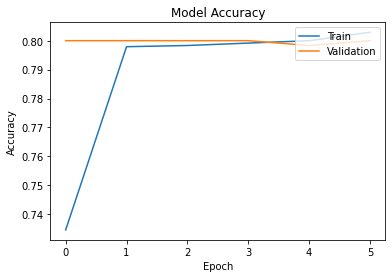

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

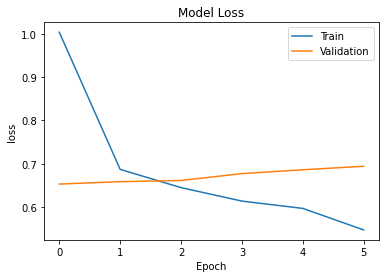

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('ImgClasif.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


98706924